# Marlow Case - TripleTen DS Course - Sprint 13 Project # 
# Predicting Taxi Orders at Airports: A Study of Time Series Forecasting Models #
___________________________________________________________________________________________________________________________________________________________

# Table of Contents #
<a id='contents'></a>
- [1. Introduction](#intro)
- [2. Imports](#imports)
- [3. Data Exploration & Preprocessing](#explore)
- [4. Exploratory Data Analysis](#eda)
    - [4.1 Hourly, Daily, Weekly, and Monthly Time Series Graphs](#resample)
    - [4.2 Mean Taxi Orders by Index](#mean)
    - [4.3 Trend & Seasonality](#trendytime)
    - [4.4 Stationarity](#station)
    - [4.5 EDA Conclusion](#eda_con)
- [5. Feature Creation](#develop)
- [6. Model Training](#training)
- [7. Model Evaluations & Analysis](#model_eval)
- [8. Conclusion](#conclusion)

# 1. Introduction #
<a id='intro'></a>
___________________________________________________________________________________________________________________________________________________________

## Purpose ##
The Sweet Lift Taxi company has provided historical data on taxi orders at airports; the data covers the period from March through August of 2018. The company's goal is to predict the amount of taxi orders in the next hour, enabling the company to attract more taxi drivers during peak demand hours.

## Model Comparisons & Evaluation ##
Like the last project, we will use two methods to sanity check our models. Below is the detailed plan for model comparisons:
- Begin with the baseline models.
    - The first includes all values of the test sample being predicted with the same number, in our case we will use the mean.
    - The second includes the value of the test sample being predicted by the previous value in the series.
- We will train two non-time-series-forecasting models: `Linear Regression` and `Random Forest`
- We will train one Gradient Boosting technique model: `LightGBM`
- We will then train a variety of Time Series Forecasting models:
    - Solo `Autoregression` using _statsmodels_
    - Solo `Moving Average` using _statsmodels_
    - `Autoregressive Moving Average` (ARMA) model using _statsmodels_
    - `Autoregressive Integrated Moving Average` model using _statsmodels_
 
## Data Description ##

**_Features:_**
- `datetime` -- Date and time of each observation.

**_Target:_**
- `num_orders` -- Number of taxi orders at the corresponding date and time.

[Back to Contents](#contents)

# 2. Imports #
<a id='imports'></a>
_________________________________________________________________________________________________________________________________________________________
As with previous projects, I like to keep all imported module sin one location organized by purpose. Those modules can be found below. 

In [1]:
# For data preprocessing
import pandas as pd
from pandas import DataFrame
from pandas import Series

import numpy as np
import time
import math

from datetime import datetime, timedelta

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, arma_order_select_ic
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

# Machine learning models
from sklearn.model_selection import (
train_test_split, cross_val_score, 
GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
)
from sklearn.preprocessing import StandardScaler

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from statsmodels.tsa.arima.model import ARIMA

# For ML metrics
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import make_scorer

[Back to Contents](#contents)

# 3. Data Exploration & Preprocessing #
<a id='explore'></a>
_________________________________________________________________________________________________________________________________________________________

The functions below will help automate tasks in this section.

In [2]:
def histplot(data, bins, title, xlabel):
    '''
    This function plots the histogram of a single column.
    '''

    # Plot the histogram
    sns.set_style('darkgrid')
    plt.figure(figsize = (5,5))

    sns.histplot(data = data,
                 bins = bins)

    plt.title(title, fontsize = 14, fontweight = 'bold')
    plt.xlabel(xlabel, fontsize = 12, fontweight = 'bold')
    plt.ylabel("Frequency of Orders", fontsize = 12, fontweight = 'bold')

    # Add the descriptive statistics
    stats = data.describe()
    stats_text = '\n'.join(
        [f'{stat}: {stats[stat]:.2f}' for stat in stats.index]
    )
    
    plt.text(x = 1.05, 
             y = 0.5, 
             s = stats_text, 
             transform = plt.gca().transAxes)

    plt.show()

In [3]:
def rice_rule(num_data_pts):
    n = num_data_pts
    bins = 2 * n ** (1/3)
    return math.ceil(bins)

=================================================================================================================

In [4]:
# Load the data
filepath = r'C:\Users\marlo\OneDrive\Desktop\Python_Work\Tripleten_Lessons\Sprint_13_Project'
filename = 'taxi.csv'

try:
    data = pd.read_csv(f"{filepath}\\{filename}",
                       index_col = ['datetime'],
                       parse_dates = ['datetime'])
    data.sort_index(inplace = True)
except:
    data = pd.read_csv(f"/datasets/{filename}",
                       index_col = ['datetime'],
                       parse_dates = ['datetime']).sort_index(inplace = True)
    data.sort_index(inplace = True)

In [5]:
# Observe the dataset
print("\033[1m")
print("<>" * 15)
print(f"Shape: {data.shape}")
print("<>" * 15)
print("\033[0m")

display(data.head())
print("\033[1m" + "<>" * 15 + "\033[0m")
print()
display(data.dtypes)
print()
print("\033[1m" + "<>" * 15 + "\033[0m")
print()
display(data.info())


<><><><><><><><><><><><><><><>
Shape: (26496, 1)
<><><><><><><><><><><><><><><>



,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<><><><><><><><><><><><><><><>



num_orders    int64
dtype: object


<><><><><><><><><><><><><><><>

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

**Items to Note:**
- Appears there are no null values among the orders.
- The datetime information is sampled every 10 minutes, we will **resample** this **to every hour**.
- The datatype for the orders is correct; impossible to have fractions of people needing picked up.

**What to Check:**
- Ensure the datetime data is in chronological order.
- Ensure no missing 10 min intervals
- Ensure no outliers in `num_orders`

In [6]:
# Check if date is chronological
data.index.is_monotonic_increasing

True

In [7]:
# Ensure no missing interval
# Calculate how many intervals there should be
start_time = data.index.min()
end_time = data.index.max()

pd.date_range(start = start_time,
              end = end_time,
              freq = '10min'
             ).difference(data.index)

DatetimeIndex([], dtype='datetime64[ns]', freq='10T')

Since the DatetimeIndex object is empty, we know that there is no 10 minute interval that doesn't exist in our dataset. Therefore, our dataset contains the appropriate number of rows for a sampling of 10 minutes.

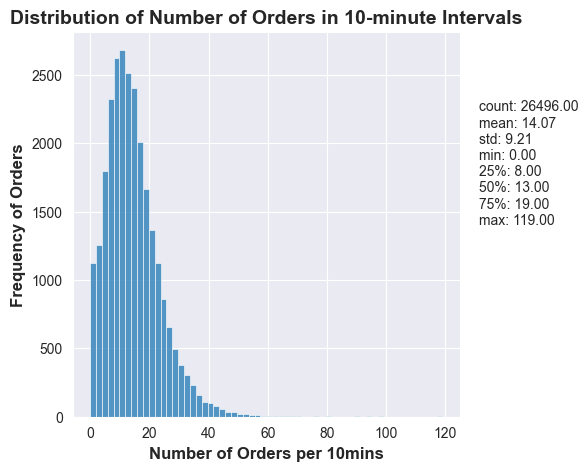

In [8]:
# Ensure no major outliers/anomalies
histplot(data = data['num_orders'], 
         bins = rice_rule(len(data['num_orders'])), #60-bins
         title = "Distribution of Number of Orders in 10-minute Intervals", 
         xlabel = 'Number of Orders per 10mins')

For this project we are less concerned about removing the outliers, as we can clearly see there are 10-min intervals that contain significantly more orders than the majority of intervals, as we are as observing them. It would be unwise to remove the outlier intervals as this is valuable information when predicting demand. 

The main reason to still investigate is to check for data entry errors, erroneous values we would remove, but extraneous values we will keep. I'd also like to bring to attention that in past projects, 0-values usually cause concern, but in this case they represent down-time in taxi orders; this information is just as valuable and high-demand time. From the chart and statistics given, there is no cause for concern over erroneous or anomalous values. 

## Resampling ##
Now that we've checked the data for chronology, missing intervals, and anomalous values, we are ready to resample the data by hour. 

In [9]:
# Resample the data
data = data.resample('1H').sum()

In [10]:
# Observe the data
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


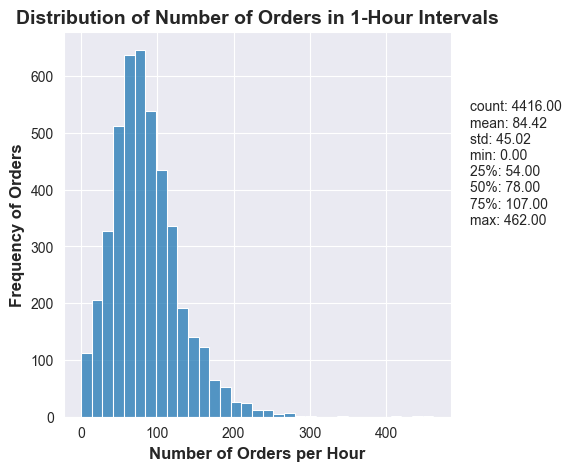

In [11]:
histplot(data = data['num_orders'], 
         bins = rice_rule(len(data['num_orders'])), # 33-bins
         title = "Distribution of Number of Orders in 1-Hour Intervals", 
         xlabel = 'Number of Orders per Hour')

The data continues to look good. No anomalous values can be observed. 

[Back to Contents](#contents)

# 4. Exploratory Data Analysis #
<a id='eda'></a>
_________________________________________________________________________________________________________________________________________________________

The functions below will help automate the tasks in this section. 

In [12]:
def sns_lineplot(df, title, ax = None, rolling = False, std = False):
    '''
    This function serves to plot time series data using the 
    lineplot from seaborn.
    '''

    sns.set(style = 'darkgrid')

    if ax is None: # no axis provided
        plt.figure(figsize = (12,4))
        sns.lineplot(x = df.index, y=df['num_orders'], label = 'Original Data')
        if rolling:
            sns.lineplot(x = df.index, y = df['rolling_mean'], 
                         label = f'Rolling Mean ({set_window_size(df)})', ax = ax,
                         color = 'orange')
        if std:
            sns.lineplot(x = df.index, y = df['std'], 
                         label = 'Standard Deviation', ax = ax,
                         color = 'green')
        plt.title(title, fontsize = 15, fontweight = 'bold')
        plt.xlabel("Date", fontsize = 12, fontweight = 'bold')
        plt.ylabel("Number of Orders", fontsize = 12, fontweight = 'bold')
        plt.xticks(rotation = 45)
        
        plt.tight_layout()
        plt.show()
    else:
        sns.lineplot(x = df.index, y=df['num_orders'], ax=ax)
        if rolling:
            sns.lineplot(x = df.index, y = df['rolling_mean'], 
                         label = f'Rolling Mean ({set_window_size(df)})', ax = ax,
                         color = 'orange')
        if std:
            sns.lineplot(x = df.index, y = df['std'], 
                         label = 'Standard Deviation', ax = ax,
                         color = 'green')
        ax.set_title(title, fontsize = 15, fontweight = 'bold')
        ax.set_xlabel("Date", fontsize = 12, fontweight = 'bold')
        ax.set_ylabel("Number of Orders", fontsize = 12, fontweight = 'bold')
        ax.tick_params(axis = 'x', rotation = 45) 

In [13]:
def set_window_size(df):
    if df.equals(data):
        ws = 24
    else:
        length = len(df)
        ws = round((length * 0.03) + 1.5)

    return ws

In [14]:
def make_features(df, time_feats = True, window_size = None, max_lag = 0):
    feats_to_make = {
        'month': df.index.month,
        'day': df.index.day,
        'day_of_week': df.index.dayofweek,
        'hour': df.index.hour
    }

    # to avoid warnings in cell 38 (loop)
    new_features = {}

    if time_feats == True:
        for feature, value in feats_to_make.items():
            new_features[feature] = value

    if window_size != None:
        new_features['rolling_mean'] = df['num_orders'].shift().rolling(window_size).mean()
        new_features['std'] = df['num_orders'].shift().rolling(window_size).std()

    if max_lag > 0:
        for i in range(1, max_lag + 1):
            lag_name = f"lag_{str(i)}"
            new_features[lag_name] = df['num_orders'].shift(i)

    # Concatenate new features to original df
    new_feats_df = pd.DataFrame(new_features, index = df.index)
    new_df = pd.concat([df, new_feats_df], axis = 1)

    new_df = new_df.dropna()
    
    return new_df

In [15]:
def plot_otsr(df, name_of_data, min_date = None, max_date = None,
              show_original = True):
    '''
    This function plots the original time series data, trend data,
    seasonality data, and residual data in one subplot.
    otsr = original_trend_seasonality_residual
    '''

    if min_date is None and max_date is None:
        decomposed = seasonal_decompose(df['num_orders'])
    else:
        if max_date is None:
            decomposed = seasonal_decompose(df['num_orders'][min_date:])
        else:
            decomposed = seasonal_decompose(df['num_orders'][min_date:max_date])

    # make compatible with function
    decomposed_dict = {
        'Original Time Series': df['num_orders'].to_frame(name= 'num_orders'),
        'Trend': decomposed.trend.to_frame(name = 'num_orders'),
        'Seasonality': decomposed.seasonal.to_frame(name = 'num_orders'),
        'Residuals': decomposed.resid.to_frame(name = 'num_orders')
    }

    # Begin figure
    if show_original == False:
        del decomposed_dict['Original Time Series']

        sns.set_style('darkgrid')
        fig, axs = plt.subplots(nrows = 3, ncols = 1,
                                figsize = (10,6), sharex = True)

        axs = axs.flatten()

        fig.suptitle(f"Trend & Seasonality Plots for {name_of_data}",
                     fontsize = 17, fontweight = 'bold',
                     x = 0.525)

        for i, (title, data_frame) in enumerate(decomposed_dict.items()):
            sns_lineplot(data_frame, title, ax = axs[i])

        plt.tight_layout()
        plt.show()
    
    else:
        
        sns.set_style('darkgrid')
        fig, axs = plt.subplots(nrows = 4, ncols = 1, 
                                figsize = (10,8), sharex = True)
        axs = axs.flatten()
        
        fig.suptitle(f"Trend & Seasonality Plots for {name_of_data}", 
                     fontsize = 17, fontweight = 'bold',
                     x = 0.525)
        
        for i, (title, data_frame) in enumerate(decomposed_dict.items()):
            sns_lineplot(data_frame, title, ax = axs[i])
        
        plt.tight_layout()
        plt.show()

## 4.1 Hourly, Daily, Weekly, and Monthly Time Series Graphs ##
<a id='resample'></a>

In [16]:
daily_ords = data.resample('1D').sum()
weekly_ords = data.resample('1W').sum()
monthly_ords = data.resample('1M').sum()

time_sets = [data, daily_ords, weekly_ords, monthly_ords]

In [17]:
# establish rolling means
for set in time_sets:
    set['rolling_mean'] = set['num_orders'].shift().rolling(set_window_size(set)).mean()
    set['std'] = set['num_orders'].shift().rolling(set_window_size(set)).std()

In [18]:
data.head(3)

,num_orders,rolling_mean,std
datetime,,,
2018-03-01 00:00:00,124,NaN,NaN
2018-03-01 01:00:00,85,NaN,NaN
2018-03-01 02:00:00,71,NaN,NaN


In [19]:
# Dictionary for different time series
series_breakdown = {
    'Hourly Time Series': data,
    'Daily Time Series': daily_ords,
    'Weekly Time Series': weekly_ords,
    'Monthly Time Series': monthly_ords
}

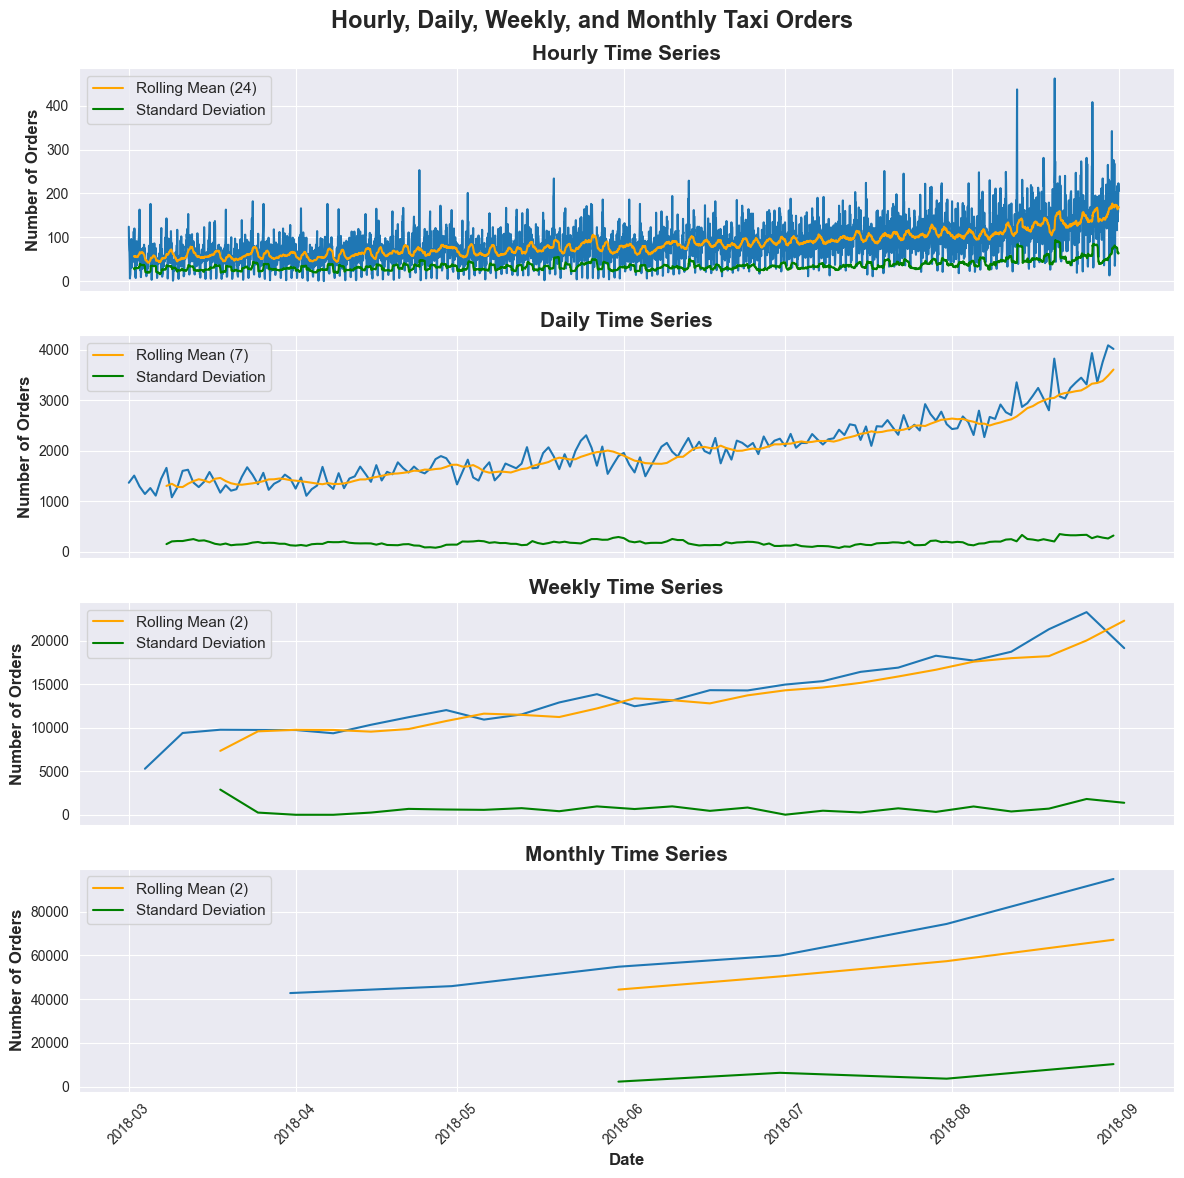

In [20]:
sns.set_style('darkgrid')
fig, axs = plt.subplots(nrows = 4, ncols = 1, 
                        figsize = (12,12), sharex = True)
axs = axs.flatten()

fig.suptitle("Hourly, Daily, Weekly, and Monthly Taxi Orders", 
             fontsize = 17, fontweight = 'bold')

for i, (title, data_set) in enumerate(series_breakdown.items()):
    sns_lineplot(data_set, title, ax = axs[i], rolling = True, std = True)

plt.tight_layout()
plt.show()

Although hard to observe in the `hourly` time series graph, the `daily`, `weekly`, and `monthly` graphs show steady growth in the number of taxi orders from March to August of 2018. In the `weekly` time series we can see that the rolling mean is close to the actual values, indicating less short-term fluctuations compared to `hourly` and `daily`. 

We can also see that in the `hourly` time series graph that the data is mostly stationary, but we cannot conclude that it is due to the rising mean. The standard deviation is relatively stationary until the end of August. We may have to perform some techniques to make the data more stationary. We will also observe the Dickey-Fuller test to quantitatively observe stationarity. 

[Back to Contents](#contents)

## 4.2 Mean Taxi Orders by Index ##
<a id='mean'></a>

Let's create some new features for our `hourly` dataset. 
We will be aiming to see: 
- Which hours of the day are the busiest;
- Which days of the week contain the most orders;
- Which month contains the most orders.
    - We only have a few months so it may be difficult to see a pattern, but let's investigate regardless just in case. 

In [21]:
data = make_features(data)
data.head()

,num_orders,rolling_mean,std,month,day,day_of_week,hour
datetime,,,,,,,
2018-03-02 00:00:00,90,56.833333,29.409650,3,2,4,0
2018-03-02 01:00:00,120,55.416667,26.730404,3,2,4,1
2018-03-02 02:00:00,75,56.875000,29.250511,3,2,4,2
2018-03-02 03:00:00,64,57.041667,29.345734,3,2,4,3
2018-03-02 04:00:00,20,56.958333,29.322019,3,2,4,4


### 4.2.1 Busiest Hours ###

In [22]:
mean_hours = pd.pivot_table(
    data = data,
    values = 'num_orders',
    index = 'hour',
    columns = None,
    aggfunc = 'mean'
).T

mean_hours

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
num_orders,144.513661,104.469945,113.300546,102.218579,87.147541,42.830601,25.245902,29.349727,73.262295,88.939891,...,75.311475,88.065574,114.535519,92.989071,69.338798,77.513661,81.972678,95.371585,98.420765,110.04918


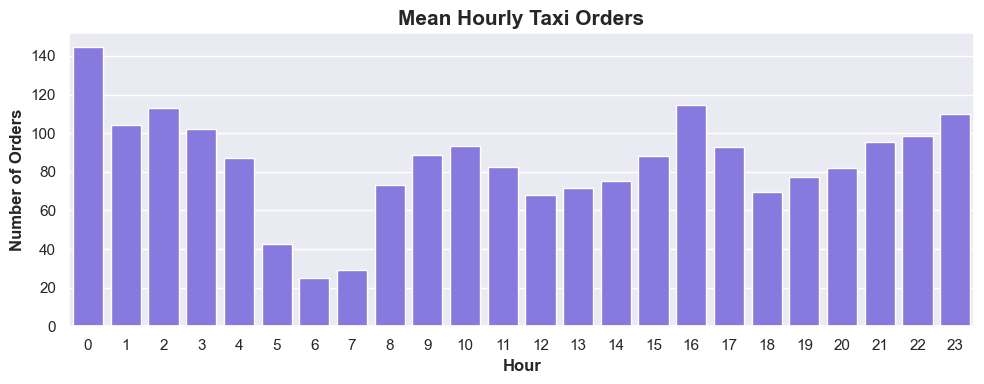

In [23]:
# Graph the mean hours
sns.set_style('darkgrid')

plt.figure(figsize = (10,4))

sns.barplot(
    data = mean_hours.T,
    x = mean_hours.T.index, y = mean_hours.T['num_orders'],
    color = 'mediumslateblue'
)

plt.title("Mean Hourly Taxi Orders", fontsize = 15, fontweight = 'bold')
plt.xlabel("Hour", fontsize = 12, fontweight = 'bold')
plt.ylabel("Number of Orders", fontsize = 12, fontweight = 'bold')

plt.tight_layout()
plt.show()

**_Notes:_**

- The number of orders is relatively steady thorughout the day past 8am with some fluctuational hours/periods.
- Peak business looks to be at midnight and the hours leading up to it.
- Hours `16-18` marks the time when most individuals get off work and we see an increase at hour 16 (4pm)
- The least active hours by a large margin are hours `5-7`. This makes sense as most individuals are still at home, and there often less flights arriving and leaving at these times. 

### 4.2.2 Busiest Days of the Week ###

In [24]:
mean_days = pd.pivot_table(
    data = data,
    values = 'num_orders',
    index = 'day_of_week',
    columns = None,
    aggfunc = 'mean'
)

days = ['Monday', 'Tuesday' ,'Wednesday' , 'Thursday', 'Friday', 'Saturday', 'Sunday']
mean_days.index = days

mean_days.T

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
num_orders,90.246795,77.011218,83.754808,86.769231,91.140432,83.847756,78.991987


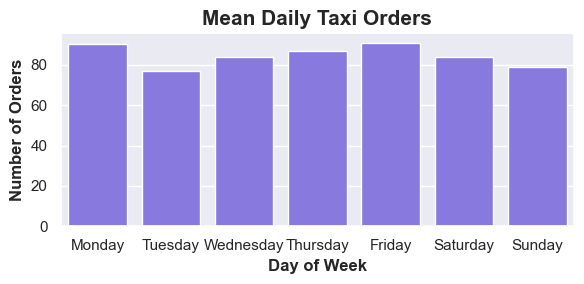

In [25]:
# Graph the mean hours
sns.set_style('darkgrid')

plt.figure(figsize = (6,3))

sns.barplot(
    data = mean_days,
    x = mean_days.index, y = mean_days['num_orders'],
    color = 'mediumslateblue'
)

plt.title("Mean Daily Taxi Orders", fontsize = 15, fontweight = 'bold')
plt.xlabel("Day of Week", fontsize = 12, fontweight = 'bold')
plt.ylabel("Number of Orders", fontsize = 12, fontweight = 'bold')

plt.tight_layout()
plt.show()

**_Notes:_**

- Relatively **uniform distribution** of the means per day of the week.
- Days with highest demand of taxi drivers are `Monday` and `Friday`.
- Day with the least demand of taxi drivers are `Tuesday` and `Sunday`.
    - Not significantly less to adjust staffing on these days.

### 4.2.3 Distribution of Orders per Month ###

In [26]:
# group per month
group_month = pd.pivot_table(
    data = data,
    index = 'month',
    columns = None,
    values = 'num_orders',
    aggfunc = 'mean'
)

months = ['March', 'April', 'May', 'June', 'July', 'August']
group_month.index = months
group_month.T

,March,April,May,June,July,August
num_orders,57.505556,63.804167,73.682796,83.202778,100.00672,127.651882


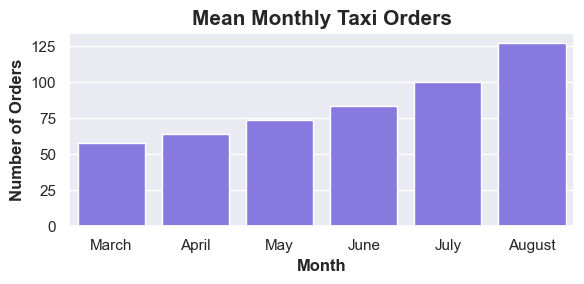

In [27]:
# Graph the mean hours
sns.set_style('darkgrid')

plt.figure(figsize = (6,3))

sns.barplot(
    data = group_month,
    x = group_month.index, y = group_month['num_orders'],
    color = 'mediumslateblue'
)

plt.title("Mean Monthly Taxi Orders", fontsize = 15, fontweight = 'bold')
plt.xlabel("Month", fontsize = 12, fontweight = 'bold')
plt.ylabel("Number of Orders", fontsize = 12, fontweight = 'bold')

plt.tight_layout()
plt.show()

It would be nice to have more data to observe any patterns or seasonality, but right now we can see a clear increase in demand for taxi drivers through the summer compared to the spring months. Which makes sense!

### 4.2.4 Hourly Orders per Day of Week ###

In [28]:
hours_per_day = pd.pivot_table(
    data = data,
    values = 'num_orders',
    index = 'day_of_week',
    columns = 'hour',
    aggfunc = 'mean'
)

hours_per_day.index = days
hours_per_day

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Monday,168.576923,135.923077,149.076923,118.269231,104.423077,49.423077,25.423077,30.192308,75.038462,96.192308,...,74.230769,97.884615,107.884615,92.576923,67.153846,79.000000,65.384615,86.653846,90.230769,94.000000
Tuesday,119.538462,98.961538,88.230769,94.884615,73.038462,37.346154,23.192308,35.653846,67.769231,80.230769,...,70.307692,85.076923,101.884615,88.307692,69.153846,74.307692,72.961538,90.538462,77.923077,109.461538
Wednesday,137.538462,81.653846,107.615385,91.576923,82.192308,40.423077,35.000000,31.423077,74.846154,87.576923,...,79.500000,79.769231,119.307692,90.307692,64.115385,90.846154,93.192308,102.038462,93.923077,112.230769
Thursday,147.961538,101.653846,123.769231,117.961538,94.807692,42.384615,14.538462,26.538462,76.846154,95.538462,...,64.653846,83.500000,124.307692,105.615385,71.346154,63.230769,82.769231,100.730769,92.230769,115.269231
Friday,145.666667,96.925926,112.740741,83.333333,84.444444,36.666667,31.592593,30.703704,75.555556,93.407407,...,77.555556,77.407407,117.592593,106.444444,86.814815,80.222222,103.333333,113.222222,146.296296,117.370370
Saturday,169.884615,133.000000,124.115385,109.038462,90.000000,49.461538,25.961538,26.961538,77.115385,95.730769,...,76.346154,98.923077,113.038462,75.846154,62.307692,78.076923,75.076923,80.346154,84.576923,96.307692
Sunday,122.384615,83.461538,87.576923,101.192308,81.230769,44.346154,20.769231,23.923077,65.576923,73.730769,...,84.500000,94.307692,117.615385,91.307692,63.807692,76.807692,80.269231,93.384615,101.923077,125.423077


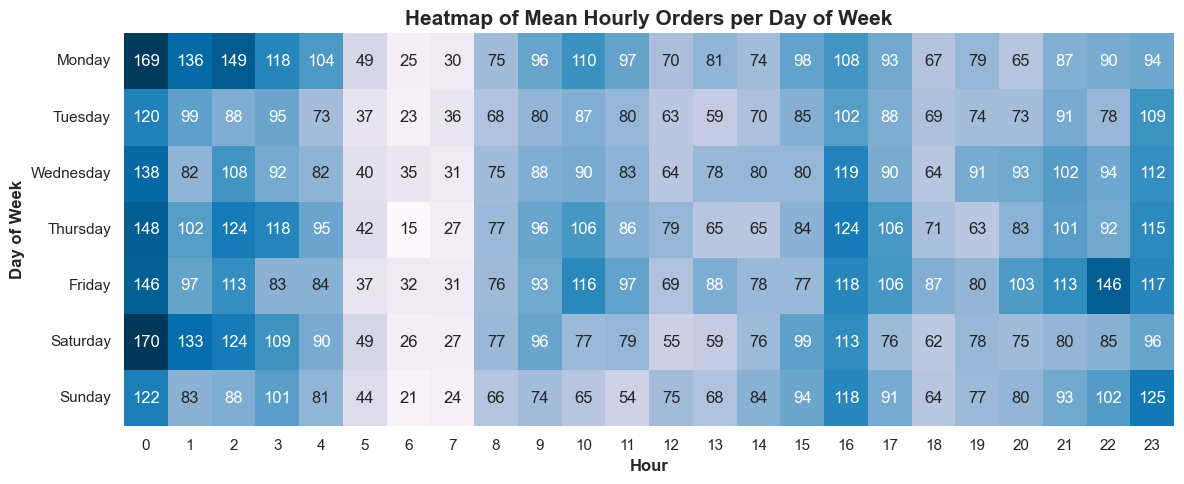

In [29]:
# Plot heatmap
plt.figure(figsize = (12,5))

sns.heatmap(hours_per_day,
            cmap = 'PuBu', annot = True,
            fmt = '.0f', cbar = False)

plt.title("Heatmap of Mean Hourly Orders per Day of Week", fontsize = 15, fontweight = 'bold')
plt.xlabel("Hour", fontsize = 12, fontweight = 'bold')
plt.ylabel("Day of Week", fontsize = 12, fontweight = 'bold')

plt.tight_layout()
plt.show()

This graph helps expand upon the patterns we were already observing. Now we can clearly see that early morning/late at night on `Mondays` and `Saturdays` are prime examples of high demand. As well as `Friday` evening moving into the early morning. We can also see that hours `0, 2, 3, 16, 21, and 23` consistently have high demand every day. While hours `10 and 11` consistently have high demand during the week and not as much on the weekend.

In fact, this consistent rise and fall in demand will give the data a daily seasonal pattern. We'll investigate that next. 

[Back to Contents](#contents)

## 4.3 Trend & Seasonality ##
<a id='trendytime'></a>

We will need to drop the `rolling_mean` and `std` columns for now. 

In [30]:
data = data.drop(columns = ['rolling_mean', 'std'])

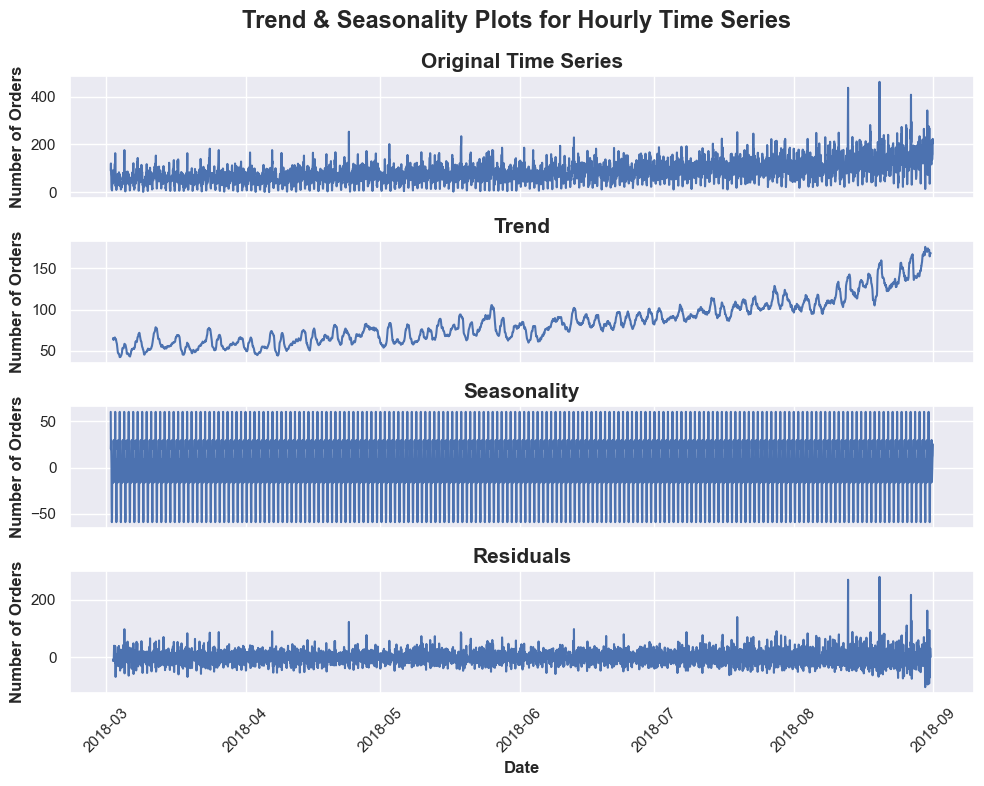

In [31]:
plot_otsr(data, "Hourly Time Series")

After decomposition of the entire time series data we can clearly see the trend line increase beginning mid-June of 2018. The seasonality chart also displays a regular pattern as we predicted earlier. Let's take a closer look at the data by observing a smaller time range to look for patterns. We will observe a 3 week interval chosen at random. 

In [32]:
# Choose start date at random
np.random.seed(54)
random_date = pd.Timestamp(np.random.choice(data.index)).to_pydatetime()
display(f"Start Date: {random_date}")
print()

# Observe 3 weeks from the given date
end_date = random_date + timedelta(days = 21)
display(f"End Date: {end_date}")

'Start Date: 2018-04-08 10:00:00'

'End Date: 2018-04-29 10:00:00'

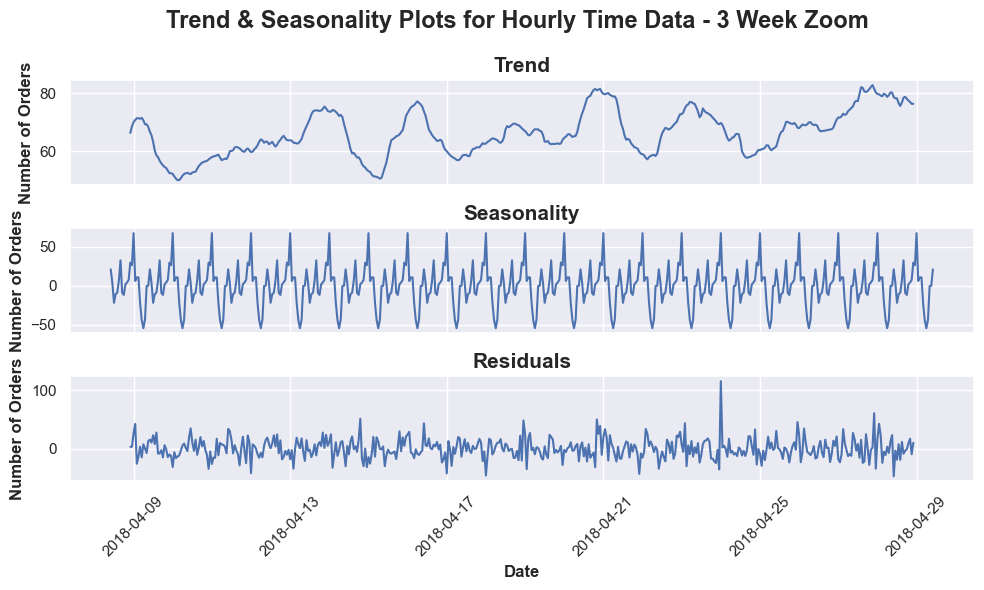

In [33]:
plot_otsr(data, "Hourly Time Data - 3 Week Zoom", 
          random_date, end_date, 
          show_original = False)

The seasonality data definitely is appearing to have a daily pattern as we predicted. Let's zoom even further to one week. 

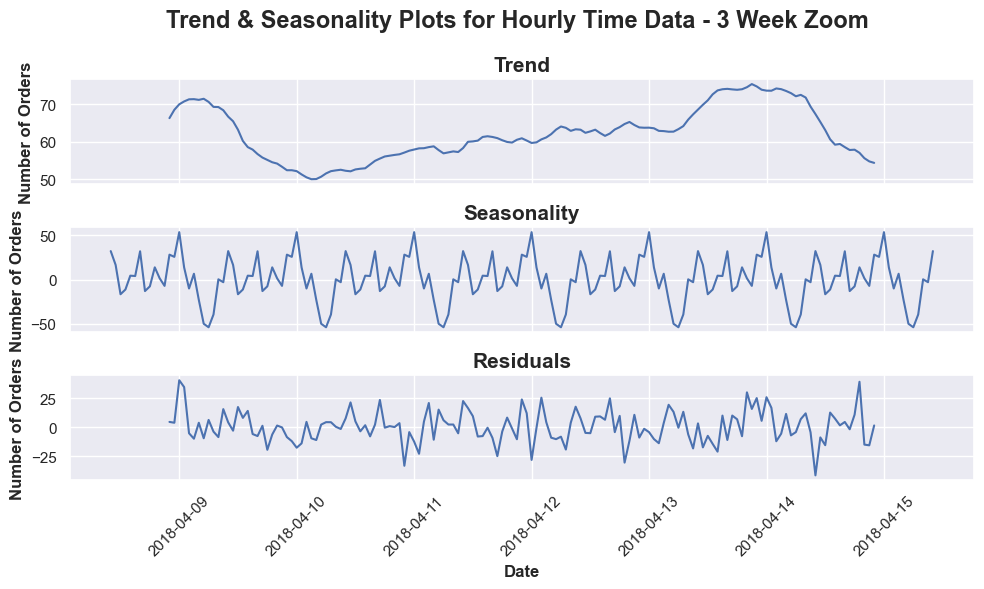

In [34]:
plot_otsr(data, "Hourly Time Data - 3 Week Zoom", 
          random_date, end_date - timedelta(days = 14), 
          show_original = False)

The dip likely lines up with the down period from 3am to 6am every day. Let's zoom further into just two days. 

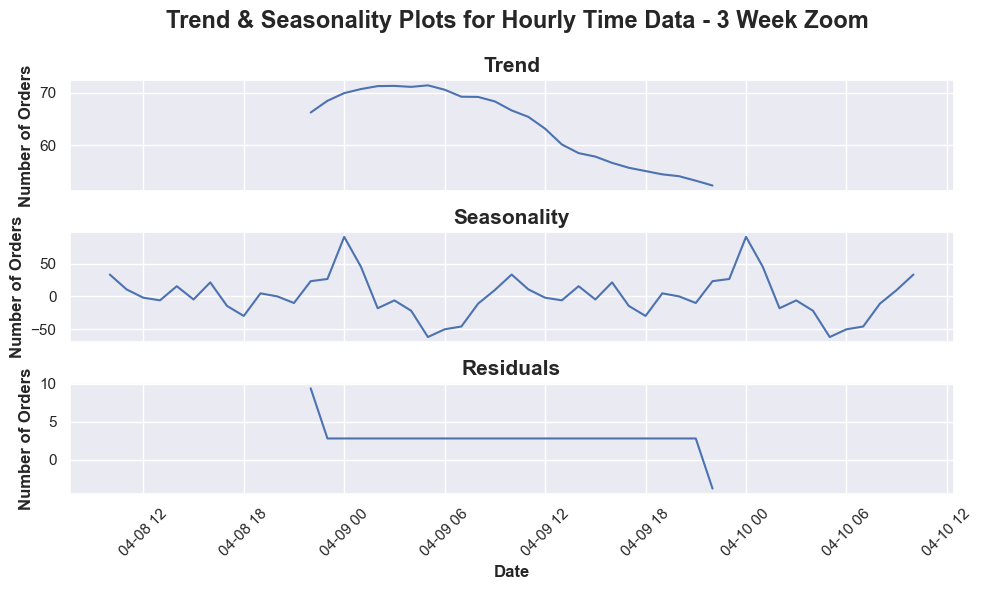

In [35]:
plot_otsr(data, "Hourly Time Data - 3 Week Zoom", 
          random_date, end_date - timedelta(days = 19), 
          show_original = False)

It appears the seasonality dips perfectly in line with the decrease in orders from 12am to 6am everyday. Exactly as we predicted. 

[Back to Contents](#contents)

## 4.4 Stationarity ##
<a id='station'></a>

Before moving into the model development stage, we will need to confirm if the data is stationary or not as most forecasting models assume stationarity. From our plots in section [4.1](#resample), we saw a mostly stationary time series graph until later in the range where the mean and standard deviation variated. Our training set will most likely be entirely stationary from this graph, but this may cause innacurate predictions. Let's refer to the Dickey-Fuller unit root test to quantitatively assess if the data is stationary. 

**$H_0$**: There is a unit root and the data is non-stationary.

**$H_1$**: There is no unit root and the data is stationary. 

**$\alpha$** = 0.05

In [36]:
# Perform the adfuller test
test_results = adfuller(data['num_orders'])

print(f"Test Statistic: {test_results[0]}")
print(f"P-Value:         {test_results[1]:.4f}")

Test Statistic: -3.025705828370018
P-Value:         0.0326


Since the p-value is less than our significance level, we reject the null hypothesis. 

The p-value inconveniently lays between a significance interval of 0.05 and 0.01. I chose 0.05 as it is a commonly used threshold and balances the risk of rejecting a true null hypothesis, however 0.01 was also considered as having a strict threshold in forecasting is also common, and would make sense for our data. 

Since we are choosing the higher significance level, there is a small chance that we might be incorrectly rejecting the null hypothesis, also known as a **Type I error**. By deciding our data is stationary with a significance level of 0.05, we are allowing a 5% chance that we could be wrong and that the data is actually non-stationary. We will accept this error possibility over being catious/strict and decide the data is indeed stationary at a 95% confidence level.

[Back to Contents](#contents)

## 4.5 EDA Conclusion ##
<a id='eda_con'></a>

We determined a few key characteristics of our data after EDA.

- The data shows an increasing trend across the 6 months provided.
- The seasonality shows a daily pattern around 6am every day. A rise in orders post 6am to 12am, and a decrease from 12am to 6am.
- The peak hours were determined to be 11pm, 12am, and 4pm.
- The dip hours were determiend to be 5-7am.
- The series is stationary with 95% confidence.

[Back to Contents](#contents)

# 5. Feature Creation #
<a id='develop'></a>
_________________________________________________________________________________________________________________________________________________________

The functions below will help automate the tasks in this section.

In [37]:
def cv_score(model, train_set, test_set):
    
    # create custom scorer
    rmse_score = make_scorer(root_mean_squared_error, greater_is_better = False)

    # Split the sets with new cv method
    tscv = TimeSeriesSplit(n_splits = 5)

    cv_score = cross_val_score(
        model,
        train_set,
        test_set,
        scoring = rmse_score,
        cv = tscv,
        n_jobs = -1
    )

    return round(cv_score.mean(), 2)

In [38]:
def rmse_fix(rmse_value):

    return round(np.abs(rmse_value), 2)

Previously we've created various features in our dataset to expand the information carried in the index: such as the hour in the day, the day of week, the day in month, and the month itself. These features will remain, but we will reintroduce the rolling features such as the rolling mean and standard deviation. For EDA, we set the window size to values that made chronoligcal sense: 24 hours, 7 days, 4 weeks, 2 months; while we could maintain these window sizes (24) for the hourly data, we could also search for the optimal value. Since our data shows a daily seasonal pattern, we will likely want the window size to be less than 24.

To properly find the best parameters, we could utilize some techniques implemented in previous projects. We will **implment a custom grid search style loop with Linear Regression to determine the optimal parameters.** 

In [39]:
data.head(3)

,num_orders,month,day,day_of_week,hour
datetime,,,,,
2018-03-02 00:00:00,90,3,2,4,0
2018-03-02 01:00:00,120,3,2,4,1
2018-03-02 02:00:00,75,3,2,4,2


In [40]:
%%time
# Create dictionary for results
window_lag_results = {
    'window_size': [],
    'max_lag': [],
    'train_rmse': [],
    'test_rmse': []
}

for window in range(2, 25):
    for lag in range(1, 21):
        
        # Create data
        data_wl = make_features(data, time_feats = False,
                                max_lag = lag, window_size = window)

        # Create training and test sets
        X_wl = data_wl.drop(columns = ['num_orders'])
        y_wl = data_wl['num_orders']
        
        X_train_wl, X_test_wl, y_train_wl, y_test_wl = train_test_split(
            X_wl, y_wl, test_size = 0.1, shuffle = False
        )

        # Train the lr model
        lr_wl = LinearRegression()

        # apply function
        train_rmse_wl = rmse_fix(cv_score(lr_wl, X_train_wl, y_train_wl))

        # evaluate
        lr_wl.fit(X_train_wl, y_train_wl)
        y_pred_wl = lr_wl.predict(X_test_wl)
        rmse_wl = round(root_mean_squared_error(y_test_wl, y_pred_wl), 2)

        # store the results
        window_lag_results['window_size'].append(window)
        window_lag_results['max_lag'].append(lag)
        window_lag_results['train_rmse'].append(train_rmse_wl)
        window_lag_results['test_rmse'].append(rmse_wl)

# Create dataframe
wl_results_df = pd.DataFrame.from_dict(window_lag_results).sort_values(by = 'test_rmse', ascending = True)
wl_results_df.head(10)

CPU times: total: 3min 11s
Wall time: 20 s


,window_size,max_lag,train_rmse,test_rmse
459,24,20,28.71,46.54
458,24,19,29.53,47.22
457,24,18,30.16,48.85
439,23,20,30.01,48.91
438,23,19,30.54,49.72
456,24,17,30.67,50.04
455,24,16,30.86,50.19
454,24,15,30.69,50.20
453,24,14,30.95,50.41
452,24,13,31.31,50.96


It appears my intuition was wrong and the optimal value for window_size was in fact 24, lucky! We have found that the ideal parameters for our rolling features are a `window_size` of **24** and a `max_lag` of **20**. These results do not show extreme signs of overfitting. But we may come back and adjust the search if the training shows signs of overfitting. 

Next we need to finalize the data with our new feature parameters and then resplit the data for model development. 

In [41]:
# Do not rerun this cell
data = make_features(data, 
                     time_feats = False, 
                     window_size = 24,
                     max_lag = 20)

In [42]:
data.head(2)

,num_orders,month,day,day_of_week,hour,rolling_mean,std,lag_1,lag_2,lag_3,...,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-03 00:00:00,163,3,3,5,0,62.750000,32.715174,72.0,119.0,101.0,...,45.0,36.0,91.0,54.0,45.0,46.0,7.0,11.0,11.0,20.0
2018-03-03 01:00:00,108,3,3,5,1,65.791667,38.279270,163.0,72.0,119.0,...,44.0,45.0,36.0,91.0,54.0,45.0,46.0,7.0,11.0,11.0


In [43]:
# convert data types
for col in data.columns:
    if data[col].dtype == np.float64:
        data[col] = data[col].astype('int32')

In [44]:
data.head(2)

,num_orders,month,day,day_of_week,hour,rolling_mean,std,lag_1,lag_2,lag_3,...,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-03 00:00:00,163,3,3,5,0,62,32,72,119,101,...,45,36,91,54,45,46,7,11,11,20
2018-03-03 01:00:00,108,3,3,5,1,65,38,163,72,119,...,44,45,36,91,54,45,46,7,11,11


In [45]:
# Make training and test sets
X = data.drop(columns = 'num_orders')
y = data['num_orders']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.1, shuffle = False
)

# Confirm the size
split_sets = {
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test
}

for name, split in split_sets.items():
    print(f"Shape of {name}: {split.shape}")

Shape of X_train: (3931, 26)
Shape of X_test: (437, 26)
Shape of y_train: (3931,)
Shape of y_test: (437,)


In [46]:
print(X_train.index.min())
print(y_test.index.max())

2018-03-03 00:00:00
2018-08-31 23:00:00


In [47]:
# scale the data
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# 6. Model Training #
<a id='training'></a>
_______________________________________________________________________________________________________________________________________________________

Below is a summary of model development process laid out in the introduction. 

For model comparisons, we'll start with two baseline models: predicting the mean and using the previous value in the series. Then, we'll train two non-time-series models: Linear Regression and Random Forest, followed by a LightGBM gradient boosting model. Finally, we'll train time-series models, including Autoregression, Moving Average, ARMA, ARIMA using statsmodels, and a pdmarima model.

In [48]:
# Create dictionary to store all results
results = {}

models_to_score = ['Dummy Mean', 'Previous Value', 'Linear Regression', 
                   'Random Forest', 'LightGBM', 'AR', 'MA', 'ARMA', 'ARIMA']

for model in models_to_score:
    results[model] = {}

## 6.1 Baseline Model - Mean ##

In [49]:
# train the dummy model
dumb_mean = DummyRegressor(strategy = 'mean')

dumb_rmse = rmse_fix(cv_score(dumb_mean, X_train, y_train))

In [50]:
# store the results
results['Dummy Mean']['best_model'] = dumb_mean
results['Dummy Mean']['best_params'] = None
results['Dummy Mean']['train_rmse'] = dumb_rmse

# Show score
print(f"The best RMSE for the Dummy Mean model is: {results['Dummy Mean']['train_rmse']}.")

The best RMSE for the Dummy Mean model is: 40.6.


==============================================================================================================

## 6.2 Previous Value Model ##

In [51]:
# Train and evaluate this baseline model
pred_prev_train = y_train.shift()
pred_prev_train.iloc[0] = 191
prev_train_rmse = root_mean_squared_error(y_train, pred_prev_train)

In [52]:
# store the results
results['Previous Value']['best_model'] = None
results['Previous Value']['best_params'] = None
results['Previous Value']['train_rmse'] = rmse_fix(prev_train_rmse)

print(f"The best RMSE for the Previous Value model is: {results['Previous Value']['train_rmse']}.")

The best RMSE for the Previous Value model is: 36.21.


==============================================================================================================

## 6.3 Linear Regression ##
We have already trained the Linear Regression model so we will move straight to storing the results.

In [53]:
# store the results
results['Linear Regression']['best_model'] = lr_wl
results['Linear Regression']['best_params'] = None
results['Linear Regression']['train_rmse'] = wl_results_df['train_rmse'].min()

print(f"The best RMSE for the Linear Regression model is: {wl_results_df['train_rmse'].min()}")

The best RMSE for the Linear Regression model is: 28.71


==============================================================================================================

## 6.4 Random Forest ##
We will first test a simple random forest model to avoid overfitting when tuning the hyperparameters.

In [54]:
%%time
rf_test = RandomForestRegressor(n_estimators = 100, random_state = 12345, n_jobs=-1)
rf_test.fit(X_train, y_train)

CPU times: total: 8.31 s
Wall time: 338 ms


RandomForestRegressor(n_jobs=-1, random_state=12345)

In [55]:
min_depth = 1e10
max_depth = 0

for i, tree in enumerate(rf_test.estimators_):
    depth = tree.get_depth()
    if depth < min_depth:
        min_depth = depth
    if depth > max_depth:
        max_depth = depth

print(f"The minimum depth of 100 trees: {min_depth}.")
print(f"The maximum depth of 100 trees: {max_depth}.")

The minimum depth of 100 trees: 23.
The maximum depth of 100 trees: 37.


Since the minimum and maximum depths of 100 trees are 23 and 37 respectively, we will set a lower value for max_depth to avoid overfitting. 

In [56]:
%%time
rf = RandomForestRegressor()
rf_grid = {
    'max_depth': range(1, 31),
    'n_estimators': range(50, 151, 10),
    'n_jobs': [-1],
    'random_state': [12345]
}

rf_rsearch = RandomizedSearchCV(
    estimator = rf,
    param_distributions = rf_grid,
    n_iter = 200,
    scoring = cv_score,
    cv = TimeSeriesSplit(n_splits = 5),
    n_jobs = -1,
    random_state = 12345
)

rf_rsearch.fit(X_train, y_train)

CPU times: total: 10.9 s
Wall time: 2min 32s


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=RandomForestRegressor(), n_iter=200, n_jobs=-1,
                   param_distributions={'max_depth': range(1, 31),
                                        'n_estimators': range(50, 151, 10),
                                        'n_jobs': [-1],
                                        'random_state': [12345]},
                   random_state=12345,
                   scoring=<function cv_score at 0x000001DE36665440>)

In [57]:
# store the results
results['Random Forest']['best_model'] = rf_rsearch
results['Random Forest']['best_params'] = rf_rsearch.best_params_
results['Random Forest']['train_rmse'] = rmse_fix(rf_rsearch.best_score_)

print(f"The best RMSE for the Random Forest model: {results['Random Forest']['train_rmse']}")

The best RMSE for the Random Forest model: 24.33


==============================================================================================================

## 6.5 LightGBM ##

In [58]:
%%time
lgbm = LGBMRegressor()

lgbm_grid = {
    'learning_rate': np.logspace(-3, 0, 10),
    'n_estimators': range(100, 501, 50),
    'max_depth': range(3, 21),
    'num_leaves': range(2, 129, 9),
    'min_data_in_leaf': [10, 20, 30, 50],
    'feature_fraction': np.linspace(0.1, 1.0, 20),
    'lambda_l2': np.logspace(-3, 2, 20),
    'lambda_l1': np.logspace(-3, 2, 20),
    'random_state': [12345]
}

lgbm_rsearch = RandomizedSearchCV(
    estimator = lgbm,
    param_distributions = lgbm_grid,
    n_iter = 200,
    scoring = cv_score,
    cv = TimeSeriesSplit(n_splits = 5),
    n_jobs = -1,
    random_state = 12345
)

lgbm_rsearch.fit(X_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5263157894736842, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5263157894736842
[LightGBM] [Warning] lambda_l1 is set=4.832930238571752, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.832930238571752
[LightGBM] [Warning] lambda_l2 is set=0.003359818286283781, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003359818286283781
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5263157894736842, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5263157894736842
[LightGBM] [Warning] lambda_l1 is set=4.832930238571752, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.832930238571752
[LightGBM] [Warning] lambda_l2 is set=0.00335981

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=LGBMRegressor(), n_iter=200, n_jobs=-1,
                   param_distributions={'feature_fraction': array([0.1       , 0.14736842, 0.19473684, 0.24210526, 0.28947368,
       0.33684211, 0.38421053, 0.43157895, 0.47894737, 0.52631579,
       0.57368421, 0.62105263, 0.66842105, 0.71578947, 0.76315789,
       0.81052...
       1.62377674e+01, 2.97635144e+01, 5.45559478e+01, 1.00000000e+02]),
                                        'learning_rate': array([0.001     , 0.00215443, 0.00464159, 0.01      , 0.02154435,
       0.04641589, 0.1       , 0.21544347, 0.46415888, 1.        ]),
                                        'max_depth': range(3, 21),
                                        'min_data_in_leaf': [10, 20, 30, 50],
                                        'n_estimators': range(100, 501, 50),
                                        'num_leaves': range(2, 129, 9),
                                        'random_state': [12345]},
                   random_state=12345,
                   scoring=<function cv_score at 0x000001DE36665440>)

In [59]:
# store the results
results['LightGBM']['best_model'] = lgbm_rsearch
results['LightGBM']['best_params'] = lgbm_rsearch.best_params_
results['LightGBM']['train_rmse'] = rmse_fix(lgbm_rsearch.best_score_)

print(f"The best RMSE for the LightGBM model: {results['LightGBM']['train_rmse']}.")

The best RMSE for the LightGBM model: 24.46.


==============================================================================================================

## 6.6 AutoRegressive Model ##

In [60]:
def arima_cv_score(model, train_set, order, splits=5):
    tscv = TimeSeriesSplit(n_splits = splits)
    rmse_scores = []

    for train_index, test_index in tscv.split(train_set):
        y_train, y_test = train_set.iloc[train_index], train_set.iloc[test_index]

        # fit the model
        arima_model = model
        arima_model = ARIMA(train_set, 
                            order = order,
                            enforce_stationarity = False,
                            enforce_invertibility = False).fit()

        # Predict the test set
        start_val = len(train_set)
        end_val = start_val + len(y_test) - 1
        y_pred = arima_model.predict(start = start_val, end = end_val)

        # evaluate
        arima_rmse = rmse_fix(root_mean_squared_error(y_test, y_pred))
        rmse_scores.append(arima_rmse)

    return rmse_fix(np.mean(rmse_scores)), model

_________________________________________________________________________________________________________________________________________________________

In [61]:
# Train and evaluate the model with training set
ar_train_rmse, ar_model = arima_cv_score(ARIMA, y_train, order = (20, 0, 0))

In [62]:
# Store the results
results['AR']['best_model'] = ar_model
results['AR']['best_params'] = (20, 0, 0)
results['AR']['train_rmse'] = ar_train_rmse

print(f"The best RMSE for the AR model: {ar_train_rmse}")

The best RMSE for the AR model: 38.64


Interesting the AR model is barely better than simply predicting the mean!

==============================================================================================================

## 6.7 Moving Average Model ##

In [63]:
res = arma_order_select_ic(y_train, max_ar=0, max_ma=10)
ma_order = res.bic_min_order[1]
ma_order

8

In [64]:
ma_train_rmse, ma_model = arima_cv_score(ARIMA, y_train, order = (0, 0, 8))

In [65]:
# Store the results
results['MA']['best_model'] = ma_model
results['MA']['best_params'] = (0, 0, 8)
results['MA']['train_rmse'] = ma_train_rmse

print(f"The best RMSE for the AR model: {ma_train_rmse}")

The best RMSE for the AR model: 38.5


Turns out to be slightly worse than the mean-only model. Let's combine the AR and MA models.

==============================================================================================================

## 6.8 AutoRegressive Moving Average Model ##

In [66]:
%%time
import warnings
warnings.filterwarnings("ignore") #not working

res = arma_order_select_ic(y_train, max_ar = 8, max_ma = 8)
ar_order = res.bic_min_order[0]
ma_order = res.bic_min_order[1]

print(f"Optimal AR order: {ar_order}")
print(f"Optimal MA order: {ma_order}")

Optimal AR order: 8
Optimal MA order: 8
CPU times: total: 9min 15s
Wall time: 5min 9s


In [67]:
%%time
# Train and evaluate the model with training set
arma_train_rmse, arma_model = arima_cv_score(ARIMA, y_train, order = (8, 0, 8))

CPU times: total: 1min 11s
Wall time: 53.8 s


In [68]:
# Store the results
results['ARMA']['best_model'] = arma_model
results['ARMA']['best_params'] = (8, 0, 8)
results['ARMA']['train_rmse'] = arma_train_rmse

print(f"The best RMSE score for the ARMA model: {arma_train_rmse}")

The best RMSE score for the ARMA model: 50.73


==============================================================================================================

## 6.9 AutoRegressive Integrated Moving Average Model ##

In [69]:
%%time

arima_train_rmse, arima_model = arima_cv_score(ARIMA, y_train, order = (10, 1, 10))
arima_train_rmse

CPU times: total: 1min 5s
Wall time: 50.3 s


49.54

In [70]:
# Store the results
results['ARIMA']['best_model'] = arima_model
results['ARIMA']['best_params'] = (10, 1, 10)
results['ARIMA']['train_rmse'] = arima_train_rmse

print(f"The best RMSE score for the ARIMA model: {arima_train_rmse}")

The best RMSE score for the ARIMA model: 49.54


==============================================================================================================

[Back to Contents](#contents)

# 7. Model Evaluations & Analysis #
<a id ='model_eval'></a>
_________________________________________________________________________________________________________________________________________________________

In [71]:
def full_eval(model, X_train, y_train, X_test, y_test):
    '''
    Function for non-time-series models.
    '''
    
    # train the model and record the time
    train_start = time.perf_counter()
    model.fit(X_train, y_train)

    train_time = round((time.perf_counter() - train_start) * 1000) #ms

    # predict on the test set
    pred_start = time.perf_counter()
    preds = model.predict(X_test)

    pred_time = round((time.perf_counter() - pred_start) * 1000)

    #calculate rmse
    rmse = rmse_fix(root_mean_squared_error(y_test, preds))

    return train_time, pred_time, rmse, model

In [72]:
def full_time_eval(model, y_train, y_test, order=None):
    '''
    Function for the time-series models.
    '''

    # train the model and record time
    train_start = time.perf_counter()

    if order:
        model = model(y_train, order = order).fit()
    else:
        model = model(y_train).fit()

    train_time = round((time.perf_counter() - train_start) * 1000) # ms

    # predict on the test
    pred_start = time.perf_counter()

    start_val = len(y_train)
    end_val = start_val + len(y_test) - 1
    preds = model.predict(start = start_val, end = end_val)

    pred_time = round((time.perf_counter() - pred_start) * 1000)

    # calc rmse
    rmse = rmse_fix(root_mean_squared_error(y_test, preds))

    return train_time, pred_time, rmse, model

In [73]:
def full_prev_val_eval(y_train, y_test):
    '''
    Function to evaluate the previous value model, since it 
    is not a model class, it will not fit into the functions above.
    '''

    train_time = 0 # this method doesn't train

    # predict the values
    pred_start = time.perf_counter()

    pred_prev = y_test.shift()
    pred_prev.iloc[0] = y_train.iloc[-1]

    pred_time = round((time.perf_counter() - pred_start) * 1000)

    # Calc RMSE
    rmse = rmse_fix(root_mean_squared_error(y_test, pred_prev))

    return train_time, pred_time, rmse

==============================================================================================================

We have performed hyperparameter tuning on all models that require it. Now that we have our model parameters, we can retrain them and validate them on the test set while simultaneously collecting time information on training and predictions. We will store all of the information in a dataframe for review and analysis afterwards. Let's use a loop to loop through the models to gather the data for the dataframe. 

In [74]:
%%time
# Final dataframe rows storage list
final_results_rows = []

for model_name in models_to_score:
    # Check model name to assign appropriate function
    if model_name in ['Dummy Mean', 'Linear Regression', 'Random Forest', 'LightGBM']:
        t_time, p_time, rmse, model = full_eval(
            model = results[model_name]['best_model'],
            X_train = X_train, 
            y_train = y_train,
            X_test = X_test, 
            y_test = y_test
        )

    elif model_name in ['AR', 'MA', 'ARMA', 'ARIMA']:
        t_time, p_time, rmse, model = full_time_eval(
            model = results[model_name]['best_model'],
            y_train = y_train,
            y_test = y_test,
            order = results[model_name]['best_params']
        )
    else:
        t_time, p_time, rmse = full_prev_val_eval(
            y_train = y_train,
            y_test = y_test
        )

    # save the results
    if model_name == 'Previous Value':
        results[model_name]['best_model'] = None
    else:
        results[model_name]['best_model'] = model

    # Create new row in final_df
    final_results_rows.append({
        'model_name': model_name,
        'train_rmse': results[model_name]['train_rmse'],
        'test_rmse': rmse,
        'train_time (ms)': t_time,
        'pred_time (ms)': p_time
    })

# Add final row to df
final_results = pd.DataFrame(final_results_rows)

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5263157894736842, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5263157894736842
[LightGBM] [Warning] lambda_l1 is set=4.832930238571752, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.832930238571752
[LightGBM] [Warning] lambda_l2 is set=0.003359818286283781, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003359818286283781
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5263157894736842, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5263157894736842
[LightGBM] [Warning] lambda_l1 is set=4.832930238571752, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.832930238571752
[LightGBM] [Warning] lambda_l2 is set=0.00335981

In [75]:
# Observe results
final_results.sort_values(by = ['test_rmse'])

,model_name,train_rmse,test_rmse,train_time (ms),pred_time (ms)
4,LightGBM,24.46,42.57,624268,1
3,Random Forest,24.33,44.70,154659,18
2,Linear Regression,28.71,46.62,3,0
1,Previous Value,36.21,59.02,0,0
8,ARIMA,49.54,59.88,9221,9
7,ARMA,50.73,66.46,9581,9
5,AR,38.64,84.20,13391,15
6,MA,38.50,84.70,1994,10
0,Dummy Mean,40.60,84.74,0,0


**Notes:**
- The `LightGBM` and `Random Forest` models perform the best in terms of the test RMSE but at the cost of higher training times, althought realistically these training times are incredible small. Technically, the `Linear Regression` model offers the best trade-off between performance and speed; however, if speed is our only focus (_along with accuracy_) then `LightGBM` is the model to choose.
- Interestingly the time series models may not have been effective in the context of this problem as they all scored below the `Dummy Mean` model, but all above the `Previous Value` model. This may be due to the convergence issue warnings that were received during evaluation of these models, so it's possible they are not configured as optimally as they could be.

**Improvements:**
- Add more models.
    - We have certainly not exhaused our model library. We could certainly test and evaluate more models, but I wanted the focus to be on the new time-series models, but I am disappointed in their performance.
- Properly tune the time series models.
    - It's possible these models are not properly tuned as they are not scoring below the baseline model of guessing previous values. 

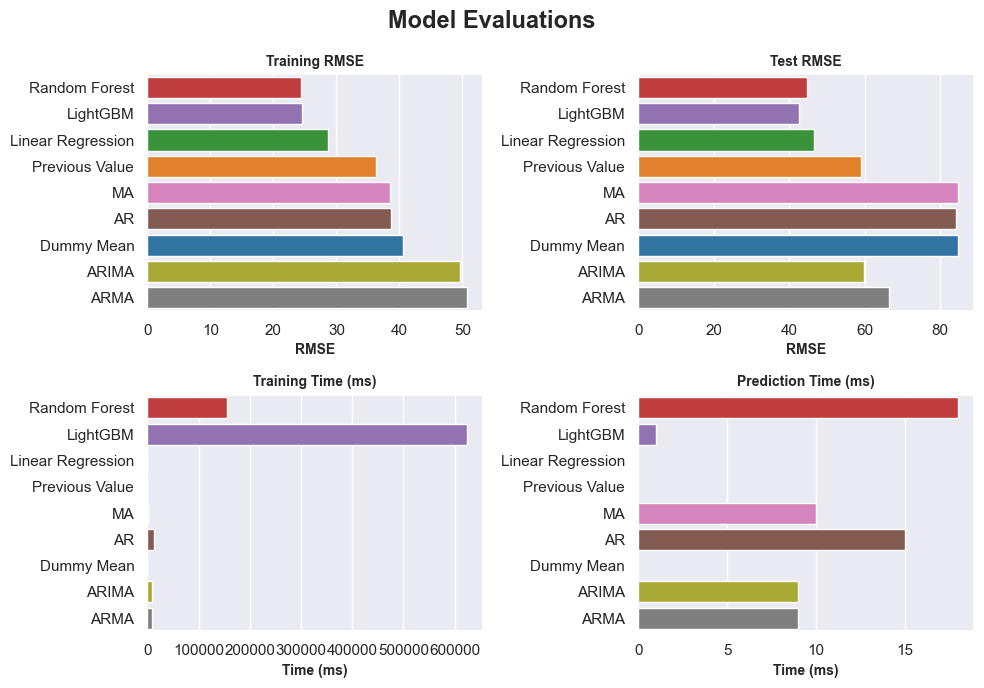

In [76]:
# Visualize the dataframe
sns.set_style('darkgrid')

palette = sns.color_palette("tab10", n_colors = 9)
model_to_color = dict(zip(final_results['model_name'].unique(), palette))

# list of characteristics to plot
metrics = ['train_rmse', 'test_rmse', 'train_time (ms)', 'pred_time (ms)']
titles = ['Training RMSE', 'Test RMSE', 'Training Time (ms)', 'Prediction Time (ms)']
xlabels = ['RMSE', 'RMSE', 'Time (ms)', 'Time (ms)']

# create the figure
fig, axs = plt.subplots(2,2, figsize = (10, 7))
plt.suptitle("Model Evaluations", fontsize = 17, fontweight = 'bold')
axs = axs.flatten()

# loop through lists 
for i, metric in enumerate(metrics):
    sorted_data = final_results.sort_values(by = metrics)

    sns.barplot(x = metric, y = 'model_name',
                data = sorted_data, ax = axs[i],
                hue = 'model_name',
                palette =  [model_to_color[m] for m in sorted_data['model_name']])

    axs[i].set_title(titles[i], fontsize = 10, fontweight = 'bold')
    axs[i].set_xlabel(xlabels[i], fontsize = 10, fontweight = 'bold')
    axs[i].set_ylabel('')

plt.tight_layout()
plt.show()

With the metrics on displayu, and based on the criteria provided by Sweet Lift Taxi: in combination of high performance and low prediction time, the `LightGBM` model will be the final model chosen for forecasting taxi orders. 

[Back to Contents](#contents)

# 8. Conclusion #
<a id='conclusion'></a>
_________________________________________________________________________________________________________________________________________________________

**Data Exploration and Preprocessing**

Sweet Lift Taxi company has provided us with a dataset that contains 26,496 rows which recorded the number of taxi orders every 10 minutes with the task of predicting the number of taxi orders for the next hour. This data spanned a period of six months from 2018-03-01 to 2018-08-31. The dataset contained no missing values or anomalous values and was resampled by one hour as requested by the taxi company. 

**Exploratory Data Analysis**

In this stage we observed the following:

- The data shows an increasing trend across the 6 months provided.
- The seasonality shows a daily pattern around 6am every day. A rise in orders post 6am to 12am, and a decrease from 12am to 6am.
- The peak hours were determined to be 11pm, 12am, and 4pm.
- The dip hours were determiend to be 5-7am.
- The series is stationary with 95% confidence.
de

**Model Training**

- We determined the best value for window size and the number of lags being 24 and 20 respectively. We also created rolling features such as the rolling mean and standard deviation. In addition to these features, various time features were created based on the index of the data.
- A total of 9 models were trained including 2 baseline models. The `Linear Regression, Random Forest, and LightGBM` models all performed well, with `LightGBM` performing the best. The time based models did not perform very well, indicating room for improvement.

**Model Evaluation**

- Overall, the `LightGBM` model is suitable to meet the requirements of Sweet Lift Taxi; it possessed the lowest `RMSE` score and has among the fastest prediction times.

[Back to Contents](#contents)